In [1]:
from Simulador import Simulador
from Registrador import Registrador
from simpy import Environment
import networkx as nx
from Cenario.GeradorDeCenarios import GeradorDeCenarios
from Cenario.Cenario import Cenario
from Variaveis import *
from Roteamento.Roteamento import Roteamento
from Roteamento.RoteamentoBestFit import RoteamentoBestFit
from ISP.ISP import ISP
from Desastre.Desastre import Desastre
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

env = Environment()
topology = nx.read_weighted_edgelist( "../topology/usa", nodetype=int)

In [2]:
#Cria cenario
import pickle

cenario = GeradorDeCenarios.gerar_cenario(topology, retornar_objetos=True, retorna_lista_de_requisicoes=True, numero_de_requisicoes=NUMERO_DE_REQUISICOES)


In [3]:
simulador = Simulador(env, topology, status_logger=True, cenario=cenario)
with open('cenario/cenarios/cenario_demonstracao.pkl', 'wb') as file:
    pickle.dump(cenario, file)
simulador.run()

dataframe = simulador.salvar_dataframe("_out/resultados/resultado_demonstracao")

10000 requests processed, time : 91.37993822606091
ISP 1 iniciando migração de 9 para 17 no tempo 174.7235440077517
ISP 4 iniciando migração de 9 para 24 no tempo 177.07579765537793
ISP 0 iniciando migração de 9 para 23 no tempo 180.5314998039243
20000 requests processed, time : 182.365309222507
ISP 2 iniciando migração de 9 para 5 no tempo 182.84368464523095
ISP 3 iniciando migração de 9 para 1 no tempo 184.76603558155966
Status ISP 1, 10.125970768496467% da migração concluída no tempo 186.87754911457446
Status ISP 3, 10.407887374142796% da migração concluída no tempo 197.37349729029592
Status ISP 4, 10.792855648276682% da migração concluída no tempo 197.414732215219
Status ISP 1, 21.00201344577045% da migração concluída no tempo 203.9131672946469
Status ISP 0, 10.008639396376811% da migração concluída no tempo 205.9891023875769
Status ISP 3, 20.49553205985043% da migração concluída no tempo 209.01244106906913
Status ISP 2, 10.555252071808292% da migração concluída no tempo 209.467192

In [4]:
#Carrega cenario
import pickle
with open('cenario/cenarios/cenario_demonstracao.pkl', 'rb') as file:
    cenario:Cenario = pickle.load(file) 

dataframe: pd.DataFrame = pd.read_csv("_out/resultados/resultado_demonstracao.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_17288\3876540885.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe: pd.DataFrame = pd.read_csv("_out/resultados/resultado_demonstracao.csv")


In [5]:
def desenhar_nodes_e_links_na_topologia( topology, nodes, links, cor, node_size=200, edge_width=2.5, weight=False):
    pos = nx.spring_layout(topology, seed=7)
    if nodes:
        nx.draw_networkx_nodes(topology, pos, nodelist=nodes, node_size=node_size, node_color=cor)
    if links:
        if len(links) == 3:
            links.append((6,6))
        nx.draw_networkx_edges(topology, pos, node_size=node_size, edgelist=links, edge_color=cor, width=edge_width)
    if weight:
        edge_labels = nx.get_edge_attributes(topology, 'weight')
        nx.draw_networkx_edge_labels(topology, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(topology, pos, font_size=11, font_family="sans-serif")

d:\IC\simulador-EON-pre-Desastre\.simulador_venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


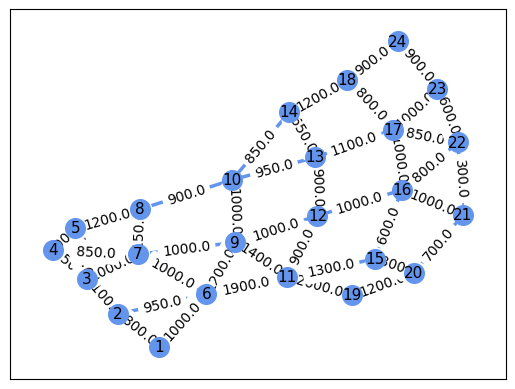

In [6]:
desenhar_nodes_e_links_na_topologia( topology, topology.nodes, topology.edges, cor=(100/255,149/255,237/255) , node_size=200, edge_width=2.5, weight=True)

In [7]:
def visao_ISP( cenario: Cenario, index_isp, global_vision=True, desenhar_database = True):

    topology = cenario.topology.topology
    ISP_alvo: ISP = cenario.lista_de_ISPs[index_isp]
    ISP_node_list = ISP_alvo.nodes
    ISP_edge_list = ISP_alvo.edges

    database_src = ISP_alvo.datacenter.source
    database_dst = ISP_alvo.datacenter.destination

    color_databases = (255/255,50/255,50/255)
    color_isp = (130/255,200/255,50/255)
    blue = (100/255,149/255,237/255)
    
    if global_vision:
        desenhar_nodes_e_links_na_topologia( topology, topology.nodes, topology.edges, blue)
    desenhar_nodes_e_links_na_topologia( topology, ISP_node_list, ISP_edge_list, color_isp)

    #desenha database
    if desenhar_database:
        desenhar_nodes_e_links_na_topologia( topology, [ database_src, database_dst ], [], color_databases)
    

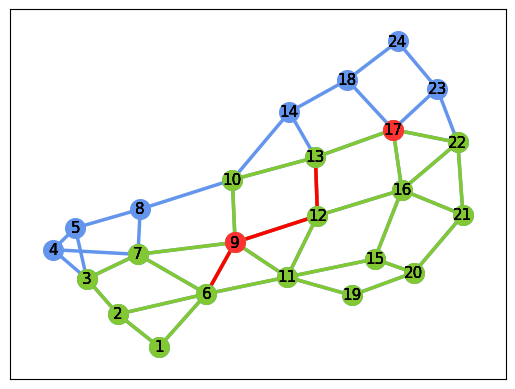

In [8]:
index = 1
gv = True
visao_ISP(cenario, index, global_vision=gv, desenhar_database=True)
desenhar_nodes_e_links_na_topologia( cenario.topology.topology, [], [(13,12), (12,9), (9,6), (6,6)], (1,0,0))

In [9]:
def desenha_desastre_e_databases( cenario: Cenario, desenha_database = True, desenha_desastre = True):
    topology = cenario.topology.topology
    desastre: Desastre = cenario.desastre

    nodes_topologia = topology.nodes
    edges_topologia = topology.edges

    nodes_desastre = [ dict['node'] for dict in desastre.list_of_dict_node_per_start_time ]    
    edges_desastre = [ (dict['src'], dict['dst']) for dict in desastre.list_of_dict_link_per_start_time ]
    reversed_edges_desastre = [ (dict['dst'], dict['src']) for dict in desastre.list_of_dict_link_per_start_time ]

    nodes_destino_database = []
    for database in cenario.lista_de_ISPs:
        database_dst = database.datacenter.destination
        nodes_destino_database.append(database_dst)

     #desenha topologia
    blue = (100/255,149/255,237/255)

    desenhar_nodes_e_links_na_topologia( topology, nodes_topologia, edges_topologia, blue)

    #desenha desastre
    if desenha_desastre:
        cor_desastre = (0/255,0/255,0/255)
        desenhar_nodes_e_links_na_topologia( topology, nodes_desastre, edges_desastre, cor_desastre)

    #desenha databases
    if desenha_database:
        color_databases = (255/255,50/255,50/255)
        desenhar_nodes_e_links_na_topologia( topology, nodes_destino_database, [], color_databases)
    
    

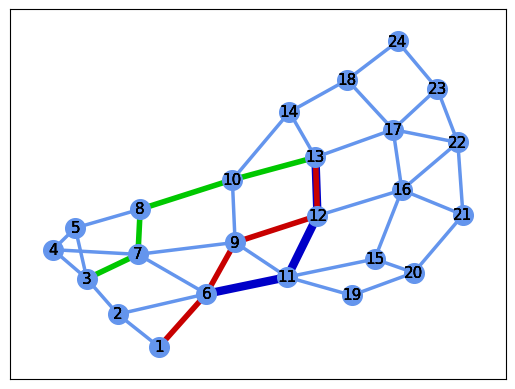

In [28]:

desenha_desastre_e_databases(cenario, desenha_database=False, desenha_desastre=False)


caminho_entre_23_7 = [13, 10, 8, 7, 3]
links_caminho = []
for i in range( len(caminho_entre_23_7)- 1):
    links_caminho.append( (caminho_entre_23_7[i], caminho_entre_23_7[i+1]) )
desenhar_nodes_e_links_na_topologia( cenario.topology.topology, [], links_caminho, (0/255,200/255,0/255), edge_width=4)

caminho_entre_23_7 = [13, 12, 11, 6]
links_caminho = []
for i in range( len(caminho_entre_23_7)- 1):
    links_caminho.append( (caminho_entre_23_7[i], caminho_entre_23_7[i+1]) )
desenhar_nodes_e_links_na_topologia( cenario.topology.topology, [], links_caminho, (0/255,0/255,200/255), edge_width=6)

caminho_entre_23_7 = [ 13, 12, 9, 6, 1]
links_caminho = []
for i in range( len(caminho_entre_23_7)- 1):
    links_caminho.append( (caminho_entre_23_7[i], caminho_entre_23_7[i+1]) )
desenhar_nodes_e_links_na_topologia( cenario.topology.topology, [], links_caminho, (200/255,0/255,0/255), edge_width=4)



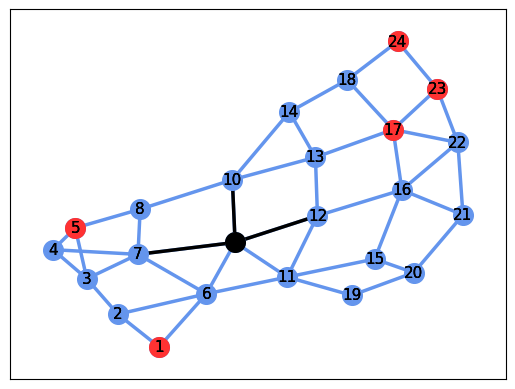

In [11]:
desenha_desastre_e_databases( cenario)

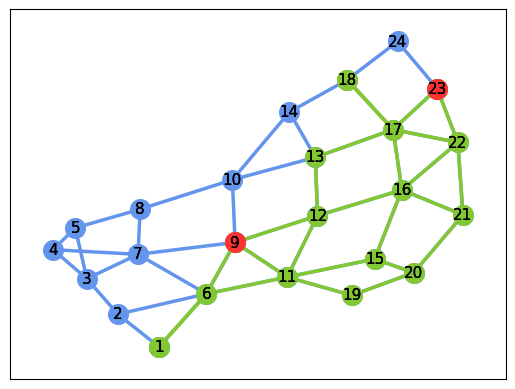

In [12]:
index = 0
gv = True
visao_ISP(cenario, index, global_vision=gv)

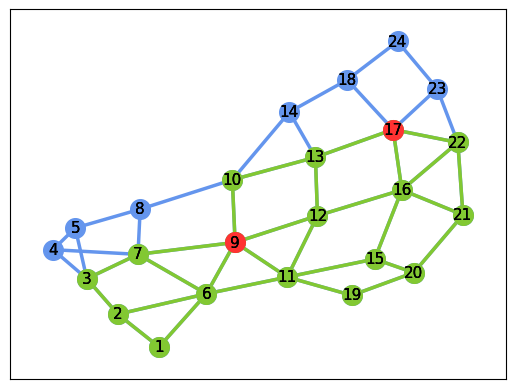

In [13]:
index = 1
gv = True
visao_ISP(cenario, index, global_vision=gv, desenhar_database=True)

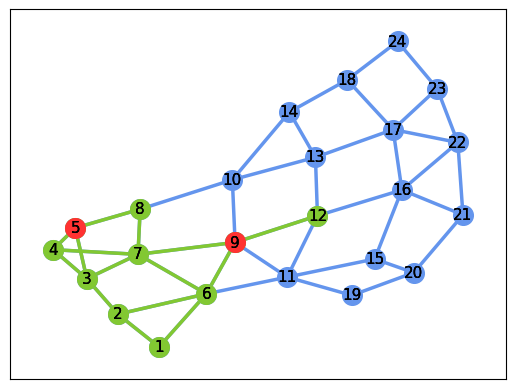

In [14]:
index = 2
gv = True
visao_ISP( cenario, index, global_vision=gv)

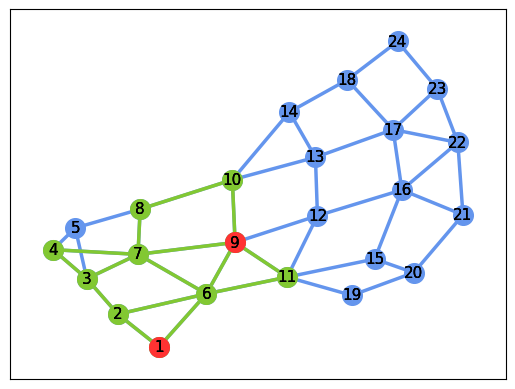

In [15]:
index = 3
gv = True
visao_ISP( cenario, index, global_vision=gv)

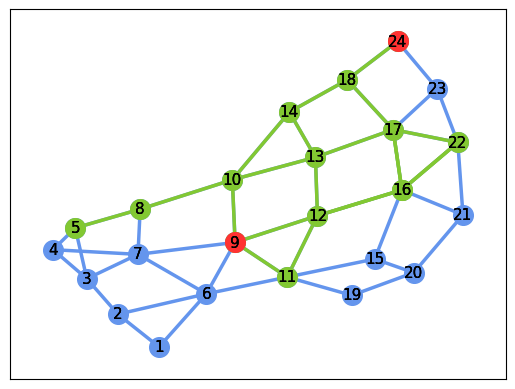

In [16]:
index = 4
gv = True
visao_ISP( cenario, index, global_vision=gv)

In [17]:
def retorna_requisicoes_da_rede_no_momento_x( x: int ) -> pd.DataFrame:
    return dataframe[ (dataframe['tempo_criacao'] < x) & (dataframe['tempo_desalocacao'] > x) ]

In [18]:
cenario_teste = deepcopy(cenario)

In [19]:
def retorna_estado_da_rede_no_momento_x( x: int, cenario: Cenario ) -> Cenario:

    for req in retorna_requisicoes_da_rede_no_momento_x( x ).to_dict(orient='records'):

        caminho = [int(i) for i in req["caminho"][1:-1].split(", ")]
        janela = [int(i) for i in req["index_de_inicio_e_final"][1:-1].split(", ")]
        cenario.topology.aloca_janela(caminho, janela)
    return cenario

In [20]:
teste = retorna_estado_da_rede_no_momento_x( 1000, cenario_teste )

In [21]:
def mostra_slots_link(cenario: Cenario, src: int, dst: int):
    slots = cenario.topology.topology[src][dst]["slots"]

    indexes_de_inicios_e_finais_de_janelas_livres = []
    last_slot_was_free = False

    for i, slot in enumerate(slots):
        if slot == 0 and not last_slot_was_free:
            # Início de uma nova janela livre
            indexes_de_inicios_e_finais_de_janelas_livres.append([i, i])
            last_slot_was_free = True

        elif slot == 0 and last_slot_was_free:
            indexes_de_inicios_e_finais_de_janelas_livres[-1][1] = i
        elif slot == 1 and last_slot_was_free:
            last_slot_was_free = False

    # Retorna a lista de janelas livres
    return indexes_de_inicios_e_finais_de_janelas_livres

In [22]:
mostra_slots_link( teste, 1, 2 )

[[0, 199]]

d:\IC\simulador-EON-pre-Desastre\.simulador_venv\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


KeyError: 0

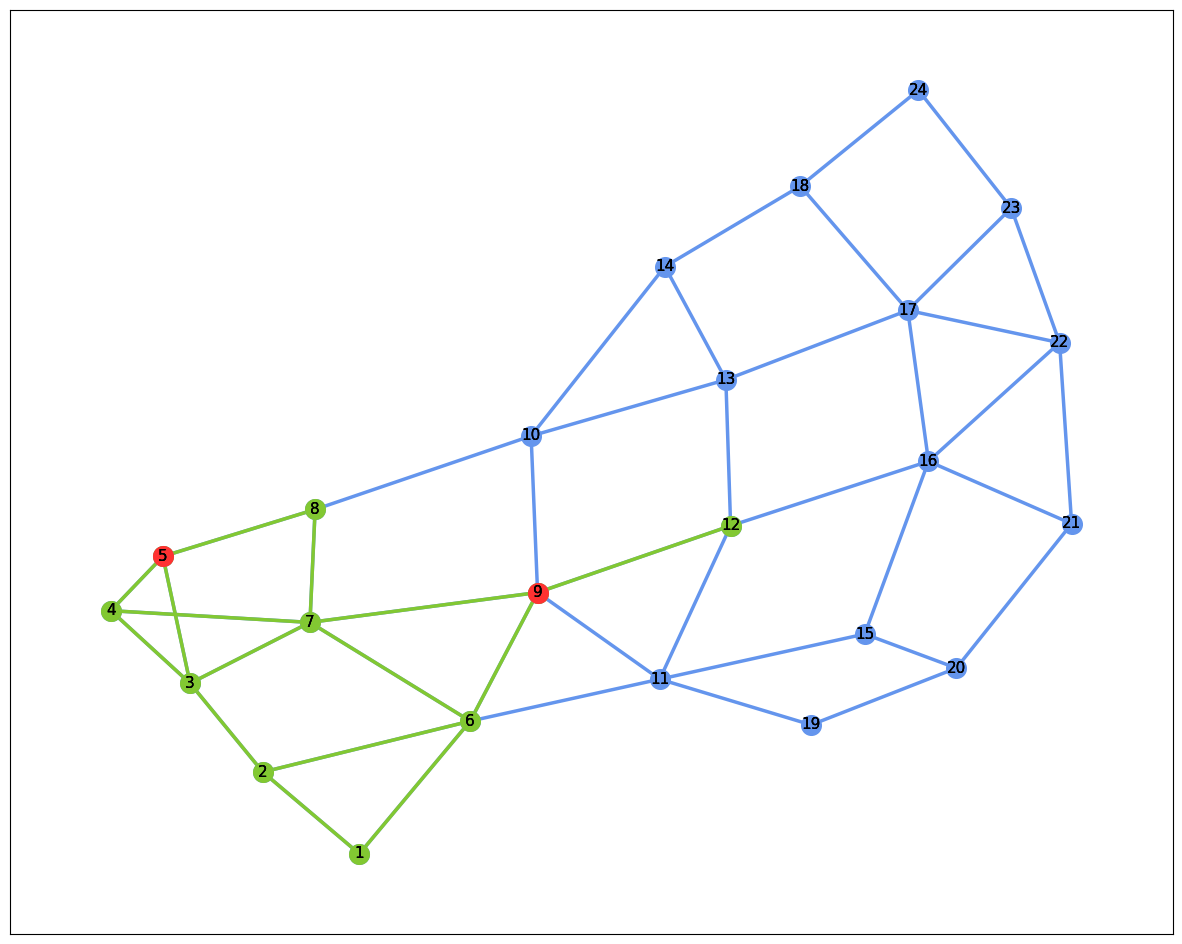

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from Topology.Topologia import Topologia
def __retorna_slots_livres( caminho, topology: 'Topologia') ->list:
    
    slots_livres = []
    for i in range( topology.numero_de_slots):
        if __checa_concurrency_slot(caminho, topology, i):
            slots_livres.append(0)
        else:
            slots_livres.append(1)
    return slots_livres

def __checa_concurrency_slot( caminho :list, topology: 'Topologia', indice: int) -> bool:

    for i in range(0, (len(caminho)-1)):
        
        if topology.topology[caminho[i]][caminho[i+1]]['slots'][indice] != 0:
            return False
    return True

def desenha_topologia_com_slots_livres(cenario: Cenario, index):
    # Extrair a topologia
    plt.figure(figsize=(15, 12), dpi=100)  # Tamanho em polegadas e resolução em DPI
    visao_ISP(cenario, index, True)
    isp: ISP = cenario.lista_de_ISPs[index]
    # Posições dos nós no gráfico
    topology: nx.Graph = cenario.topology.topology
    topologia: Topologia = cenario.topology

    pos = nx.spring_layout( topology, seed=7)  
    dc_src = isp.datacenter.source
    dc_dst = isp.datacenter.destination

    caminhos = topologia.caminhos_mais_curtos_entre_links[dc_src][dc_dst]
    found = False
    for i, caminho in enumerate(caminhos):
        slots_livres = __retorna_slots_livres(caminho, topologia)
        #print(slots_livres)
        indexes_de_inicios_e_finais_de_janelas_livres = []
        last_slot_was_free = False

        for i, slot in enumerate(slots_livres):

            if slot == 0 and not last_slot_was_free:
                # Início de uma nova janela livre
                indexes_de_inicios_e_finais_de_janelas_livres.append([i, i])
                last_slot_was_free = True

            elif slot == 0 and last_slot_was_free:
                indexes_de_inicios_e_finais_de_janelas_livres[-1][1] = i
            elif slot == 1 and last_slot_was_free:
                last_slot_was_free = False

    
        for janela in indexes_de_inicios_e_finais_de_janelas_livres:
            if janela[1] - janela[0] + 1 > 12:
                links = []
                for i in range(0, len(caminho) - 1):
                    links.append((caminho[i], caminho[i + 1]))

                print(f"indice do caminho encontrado: {i}\nslots livres agrupados: {indexes_de_inicios_e_finais_de_janelas_livres}\ncaminho: {caminho}")
                nx.draw_networkx_edges(topology, pos, edgelist=links, edge_color='red', width=2.5)
                found = True
                break
        if found:
            break
                


        
    


    # Configurar o título e exibir o gráfico
    plt.title(f'Topologia com Janelas de Slots Livres')
    plt.grid(True)
    plt.show()

# Exemplo de uso da função
cenario_teste = retorna_estado_da_rede_no_momento_x( 1000, cenario_teste )
desenha_topologia_com_slots_livres(cenario_teste, 2 )
